In [1]:
# data access
import earthaccess

# custom tool functions
import importlib
import tools
import makeL3_scripts
importlib.reload(tools)
importlib.reload(makeL3_scripts)
from tools import *
from makeL3_scripts import makeL3, path_to_gridded_ds

# data manipulation
import numpy as np
import xarray as xr
import cf_xarray  # noqa: F401
import rasterio
import rioxarray as rio

from rasterio.enums import Resampling
from tqdm import tqdm

# plotting
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [50]:
loc = "SEP"
res = 1.0
strres = {1.0:"1deg", 0.1:"0p1deg"}[res]

xlim = {"SEP":[20,3e3], "SO":[1,3e3]}
ylim = {"SEP":[1,3e2], "SO":[5,1e3]}

In [51]:
fileL3 = "/home/jovyan/shared-public/mucloud-hackweek2025-data/harpL3."+loc+"."+strres+".nc"

In [52]:
ds = xr.open_dataset(fileL3)
ds

<xarray.Dataset> Size: 12MB
Dimensions:                                           (time: 184, latitude: 26,
                                                       longitude: 41)
Coordinates:
  * time                                              (time) datetime64[ns] 1kB ...
  * latitude                                          (latitude) float64 208B ...
  * longitude                                         (longitude) float64 328B ...
Data variables: (12/14)
    cloud_bow_droplet_effective_radius                (time, latitude, longitude) float32 785kB ...
    cloud_bow_droplet_effective_variance              (time, latitude, longitude) float32 785kB ...
    cloud_bow_droplet_number_concentration_adiabatic  (time, latitude, longitude) float32 785kB ...
    cloud_bow_liquid_water_path                       (time, latitude, longitude) float32 785kB ...
    cloud_rft_droplet_effective_radius_mode_0         (time, latitude, longitude) float32 785kB ...
    cloud_rft_droplet_effective_radius_mode_1         (time, latitude, longitude) float32 785kB ...
    ...                                                ...
    cloud_rft_mode_fraction_0                         (time, latitude, longitude) float32 785kB ...
    cloud_rft_mode_fraction_1                         (time, latitude, longitude) float32 785kB ...
    cloud_top_altitude                                (time, latitude, longitude) float32 785kB ...
    cloud_top_temperature                             (time, latitude, longitude) float32 785kB ...
    cloud_top_pressure                                (time, latitude, longitude) float32 785kB ...
    cloud_liquid_index_mask                           (time, latitude, longitude) float64 2MB ...
Attributes: (12/110)
    Conventions:                                            CF-1.10
    acquisition_scheme:                                     4
    att_pitch_start_end_degrees:                            [-0.12239729 -0.1...
    att_roll_start_end_degrees:                             [-0.3231854  -0.3...
    att_time_offset:                                        0.0
    att_yaw_start_end_degrees:                              [-12.033219 -12.4...
    ...                                                     ...
    cloud_rft_lut_file_name:                                /sdps/sdpsoper/Sc...
    cloud_rft_scatt_angle_required_min:                     135.83791174582538
    cloud_rft_scatt_angle_required_max:                     150.0
    cloud_rft_scatt_angle_to_use_lo:                        135.83791174582538
    cloud_rft_scatt_angle_to_use_hi:                        165.0
    cloud_rft_decomposition_size_correlation_required_min:  0.95

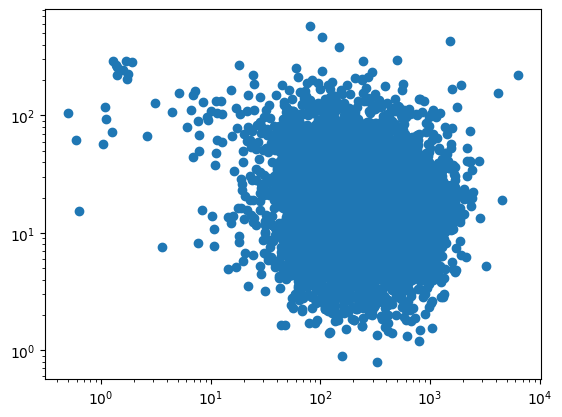

In [53]:
plt.scatter(ds.cloud_bow_droplet_number_concentration_adiabatic, ds.cloud_bow_liquid_water_path)
plt.xscale("log")
plt.yscale("log")
plt.show()

In [54]:
ds_filter = ds.where(ds.cloud_liquid_index_mask > 0.5)

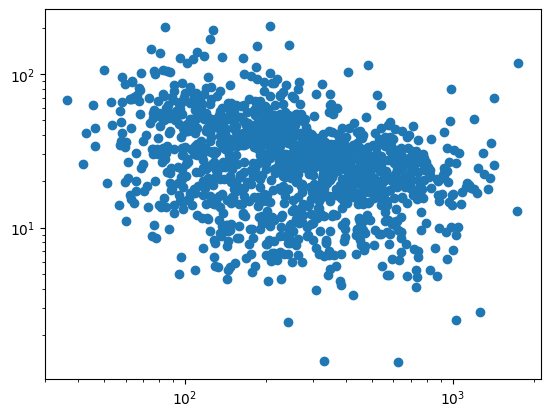

In [55]:
plt.scatter(ds_filter.cloud_bow_droplet_number_concentration_adiabatic, ds_filter.cloud_bow_liquid_water_path)
plt.xscale("log")
plt.yscale("log")
plt.show()

In [56]:
from xarray.groupers import BinGrouper

nd_bins = np.geomspace(1,2000,num=50)
lwp_bins = np.geomspace(1,1000,num=45)

ds_binned = ds_filter.groupby(
    cloud_bow_droplet_number_concentration_adiabatic=BinGrouper(bins=nd_bins),
    cloud_bow_liquid_water_path=BinGrouper(bins=lwp_bins),
).mean()
bincounts = ds_filter.groupby(
    cloud_bow_droplet_number_concentration_adiabatic=BinGrouper(bins=nd_bins),
    cloud_bow_liquid_water_path=BinGrouper(bins=lwp_bins),
).count()

ds_binned["counts"] = bincounts.cloud_bow_liquid_water_path
ds_binned.counts.attrs = {
    'long_name': 'counts per bin',
    'units': '',
    'valid_min': np.float32(0.0),
    'valid_max': np.inf,
    'grid_mapping': 'spatial_ref'}

ds_binned

<xarray.Dataset> Size: 148kB
Dimensions:                                                (
                                                            cloud_bow_droplet_number_concentration_adiabatic_bins: 49,
                                                            cloud_bow_liquid_water_path_bins: 44)
Coordinates:
  * cloud_bow_droplet_number_concentration_adiabatic_bins  (cloud_bow_droplet_number_concentration_adiabatic_bins) interval[float64, right] 784B ...
  * cloud_bow_liquid_water_path_bins                       (cloud_bow_liquid_water_path_bins) interval[float64, right] 704B ...
Data variables: (12/15)
    cloud_bow_droplet_effective_radius                     (cloud_bow_droplet_number_concentration_adiabatic_bins, cloud_bow_liquid_water_path_bins) float32 9kB ...
    cloud_bow_droplet_effective_variance                   (cloud_bow_droplet_number_concentration_adiabatic_bins, cloud_bow_liquid_water_path_bins) float32 9kB ...
    cloud_bow_droplet_number_concentration_adiabatic       (cloud_bow_droplet_number_concentration_adiabatic_bins, cloud_bow_liquid_water_path_bins) float32 9kB ...
    cloud_bow_liquid_water_path                            (cloud_bow_droplet_number_concentration_adiabatic_bins, cloud_bow_liquid_water_path_bins) float32 9kB ...
    cloud_rft_droplet_effective_radius_mode_0              (cloud_bow_droplet_number_concentration_adiabatic_bins, cloud_bow_liquid_water_path_bins) float32 9kB ...
    cloud_rft_droplet_effective_radius_mode_1              (cloud_bow_droplet_number_concentration_adiabatic_bins, cloud_bow_liquid_water_path_bins) float32 9kB ...
    ...                                                     ...
    cloud_rft_mode_fraction_1                              (cloud_bow_droplet_number_concentration_adiabatic_bins, cloud_bow_liquid_water_path_bins) float32 9kB ...
    cloud_top_altitude                                     (cloud_bow_droplet_number_concentration_adiabatic_bins, cloud_bow_liquid_water_path_bins) float32 9kB ...
    cloud_top_temperature                                  (cloud_bow_droplet_number_concentration_adiabatic_bins, cloud_bow_liquid_water_path_bins) float32 9kB ...
    cloud_top_pressure                                     (cloud_bow_droplet_number_concentration_adiabatic_bins, cloud_bow_liquid_water_path_bins) float32 9kB ...
    cloud_liquid_index_mask                                (cloud_bow_droplet_number_concentration_adiabatic_bins, cloud_bow_liquid_water_path_bins) float64 17kB ...
    counts                                                 (cloud_bow_droplet_number_concentration_adiabatic_bins, cloud_bow_liquid_water_path_bins) float64 17kB ...
Attributes: (12/110)
    Conventions:                                            CF-1.10
    acquisition_scheme:                                     4
    att_pitch_start_end_degrees:                            [-0.12239729 -0.1...
    att_roll_start_end_degrees:                             [-0.3231854  -0.3...
    att_time_offset:                                        0.0
    att_yaw_start_end_degrees:                              [-12.033219 -12.4...
    ...                                                     ...
    cloud_rft_lut_file_name:                                /sdps/sdpsoper/Sc...
    cloud_rft_scatt_angle_required_min:                     135.83791174582538
    cloud_rft_scatt_angle_required_max:                     150.0
    cloud_rft_scatt_angle_to_use_lo:                        135.83791174582538
    cloud_rft_scatt_angle_to_use_hi:                        165.0
    cloud_rft_decomposition_size_correlation_required_min:  0.95

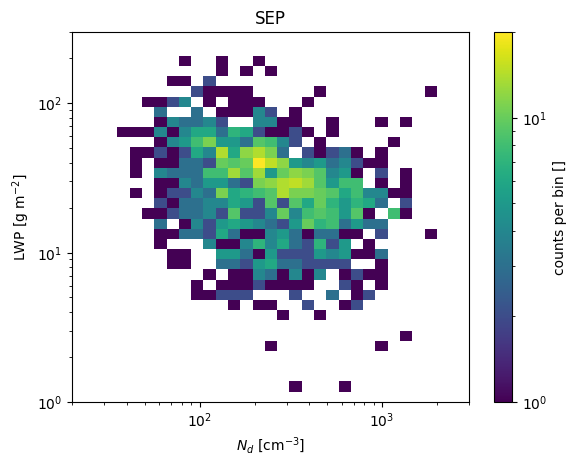

In [57]:
var = "counts"
ds_binned[var].plot.pcolormesh(
    x="cloud_bow_droplet_number_concentration_adiabatic_bins",
    y="cloud_bow_liquid_water_path_bins",
    norm=LogNorm())
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$N_d$ [cm$^{-3}$]")
plt.ylabel("LWP [g m$^{-2}$]")
plt.xlim(xlim[loc])
plt.ylim(ylim[loc])
plt.title(loc)
plt.show()

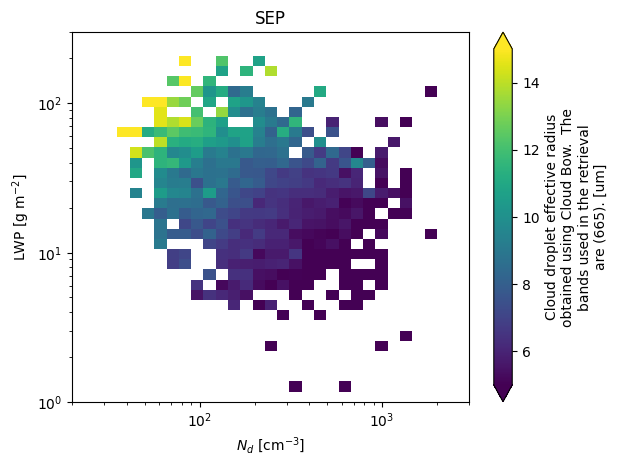

In [62]:
var = "cloud_bow_droplet_effective_radius"
ds_binned[var].plot.pcolormesh(
    x="cloud_bow_droplet_number_concentration_adiabatic_bins",
    y="cloud_bow_liquid_water_path_bins",
    vmin=5,vmax=15
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$N_d$ [cm$^{-3}$]")
plt.ylabel("LWP [g m$^{-2}$]")
plt.xlim(xlim[loc])
plt.ylim(ylim[loc])
plt.title(loc)
plt.show()

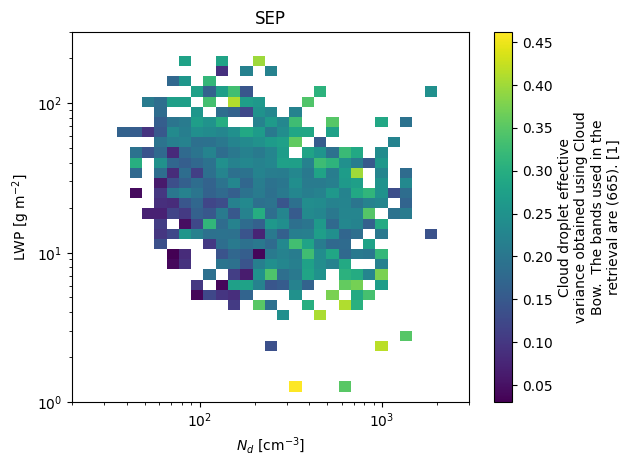

In [59]:
var = "cloud_bow_droplet_effective_variance"
ds_binned[var].plot.pcolormesh(
    x="cloud_bow_droplet_number_concentration_adiabatic_bins",
    y="cloud_bow_liquid_water_path_bins"
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$N_d$ [cm$^{-3}$]")
plt.ylabel("LWP [g m$^{-2}$]")
plt.xlim(xlim[loc])
plt.ylim(ylim[loc])
plt.title(loc)
plt.show()

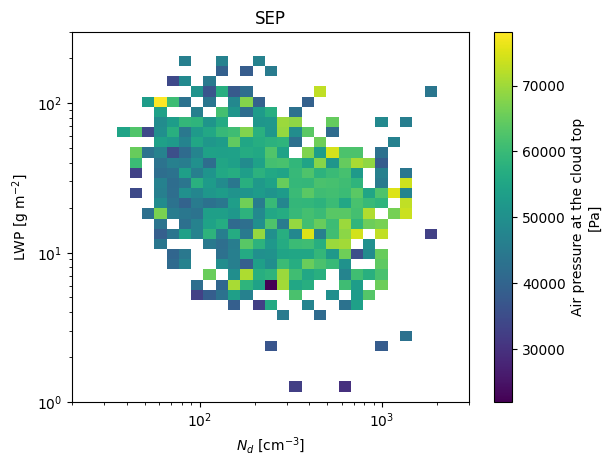

In [66]:
var = "cloud_top_pressure"
ds_binned[var].plot.pcolormesh(
    x="cloud_bow_droplet_number_concentration_adiabatic_bins",
    y="cloud_bow_liquid_water_path_bins",
    # vmin=5e4,vmax=7e4
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$N_d$ [cm$^{-3}$]")
plt.ylabel("LWP [g m$^{-2}$]")
plt.xlim(xlim[loc])
plt.ylim(ylim[loc])
plt.title(loc)
plt.show()